# Tumor Growth Model Analysis

This notebook analyzes and improves the tumor growth model for estimating primary tumor expansion age. We'll:
1. Analyze the current model and data
2. Implement an improved model
3. Perform sensitivity analysis
4. Explore additional analytical approaches

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Set plotting style
#plt.style.use('seaborn-white')
sns.set_theme(style="whitegrid") 
sns.set_palette("CMRmap")

# Update plotting parameters
plt.rcParams['figure.dpi'] = 300
sns.set(rc={'figure.dpi': 300})
#plt.rcParams['axes.grid'] = True  # Remove gridlines
#plt.rcParams['axes.spines.right'] = True  # Remove right spine
#plt.rcParams['axes.spines.top'] = False   # Remove top spine
plt.rcParams['axes.facecolor'] = 'white'  # Set white background

## 1. Data Loading and Initial Analysis

We have loaded data from **eight** studies containing cohort-level data about the growth characteristics of pheochromocytomas and paragangliomas. The studies are:
* Tamaki et al (2022). PMID: 34972002
* Michałowska et al (2017). PMID: 27967220
* Jansen et al (2000). PMID: 10870065
* Walther et al (1999). PMID: 10458336
* Wang et al (2016). PMID: 27073708
* Heesterman et al (2017). PMID: 29134169
* Tooker et al (2023). PMID: 37590887
* Carlson et al (2015). PMID: 25361637

Let's begin with a quick exploratory analysis of the basic variables in the data.

In [3]:
# Load data
dt = pd.read_excel('../../metadata/PPGL_doubling_time_estimates.xlsx', sheet_name='doubling_time')
diam = pd.read_excel('../../metadata/PPGL_doubling_time_estimates.xlsx', sheet_name='volume')

# Calculate weighted statistics for doubling time
weights_dt = dt['num_tumors'] / dt['num_tumors'].sum()

dt_min = dt['doubling_time'].min() * 365
dt_max = dt['doubling_time'].max() * 365
dt_median = np.average(dt['doubling_time'], weights=weights_dt) * 365

# Calculate weighted quartiles for doubling time
def weighted_quantile(values, weights, q):
    indices = np.argsort(values)
    sorted_values = values[indices]
    sorted_weights = weights[indices]
    cumsum = np.cumsum(sorted_weights)
    cumsum = cumsum / cumsum[-1]
    return np.interp(q, cumsum, sorted_values)

dt_1qt = weighted_quantile(dt['doubling_time'].values, weights_dt.values, 0.25) * 365
dt_3qt = weighted_quantile(dt['doubling_time'].values, weights_dt.values, 0.75) * 365

# Constants
limit_size = 1e11
log_limit_size = np.log(limit_size)

# Calculate weighted statistics for volume
weights_vol = diam['num_tumors'] / diam['num_tumors'].sum()
vol = np.average(diam['volume_cm'], weights=weights_vol)
vol_min = diam['volume_cm'].min()
vol_max = diam['volume_cm'].max()

vol_1qt = weighted_quantile(diam['volume_cm'].values, weights_vol.values, 0.25)
vol_3qt = weighted_quantile(diam['volume_cm'].values, weights_vol.values, 0.75)

# Convert volumes to sizes
dx_size = vol * 1e8
dx_size_min = vol_min * 1e8
dx_size_max = vol_max * 1e8
dx_size_1q = vol_1qt * 1e8
dx_size_3q = vol_3qt * 1e8

In [4]:
def calculate_growth_parameters(time_vals, size_vals):
    """Calculate growth parameters for combinations of time and size values"""
    results = []
    
    for time in time_vals:
        for size in size_vals:
            try:
                # Calculate beta
                beta = 1/time * np.log(
                    (log_limit_size - np.log(size)) / 
                    (log_limit_size - np.log(2 * size))
                )
                
                # Calculate alpha
                alpha = log_limit_size * beta
                
                # Calculate expected age
                exp_age = -1 / beta * np.log(1 - np.log(size) * beta / alpha) / 365
                
                if exp_age < 100:  # Filter ages greater than lifespan
                    results.append({
                        'time': time,
                        'size': size,
                        'beta': beta,
                        'alpha': alpha,
                        'age': exp_age
                    })
            except:
                continue
    
    return pd.DataFrame(results)


def calculate_trajectories(df, alpha_col='alpha', beta_col='beta', age_col='age'):
    """
    Calculate growth trajectories for each parameter combination.

    Parameters:
    - df (DataFrame): Input dataframe containing the required columns.
    - exp_age_col (str): Column name for expected age.
    - alpha_col (str): Column name for alpha parameter.
    - beta_col (str): Column name for beta parameter.
    - age_col (str): Column name for age parameter.

    Returns:
    - DataFrame: Concatenated DataFrame with growth trajectories.
    """
    trajectories = []
    
    for _, row in df.iterrows():
        time_steps = np.arange(0, 90, 0.01)
        time_steps2 = time_steps - row[age_col]
        
        # Calculate St (size at time t)
        St = np.exp(row[alpha_col] / row[beta_col] * 
                    (1 - np.exp(-row[beta_col] * time_steps * 365)))
        
        trajectory_df = pd.DataFrame({
            'time_step': time_steps,
            'time_step2': time_steps2,
            'St': St,
            'alpha': row[alpha_col],
            'beta': row[beta_col],
            'exp_age': row[age_col]
        })
        
        trajectories.append(trajectory_df)
    
    return pd.concat(trajectories)


In [5]:
# Set up parameters for both models
time_vals = np.array([dt_1qt, dt_median, dt_3qt])
size_vals = np.array([dx_size_min, dx_size_1q, dx_size, dx_size_3q, dx_size_max])

# Calculate results for the weighted model
df_weighted = calculate_growth_parameters(time_vals, size_vals)
df_weighted.head(10)

,time,size,beta,alpha,age
0,1631.550000,3.200000e+07,0.000055,0.001398,56.902036
1,1631.550000,1.954688e+08,0.000072,0.001829,53.175371
2,1631.550000,5.014432e+08,0.000086,0.002178,49.866987
3,1631.550000,6.370654e+08,0.000090,0.002289,48.849121
4,1631.550000,3.250000e+09,0.000139,0.003509,39.563503
5,2438.851786,3.200000e+07,0.000037,0.000935,85.057541
6,2438.851786,1.954688e+08,0.000048,0.001223,79.486899
7,2438.851786,5.014432e+08,0.000058,0.001457,74.541504
8,2438.851786,6.370654e+08,0.000060,0.001531,73.019991
9,2438.851786,3.250000e+09,0.000093,0.002347,59.139788


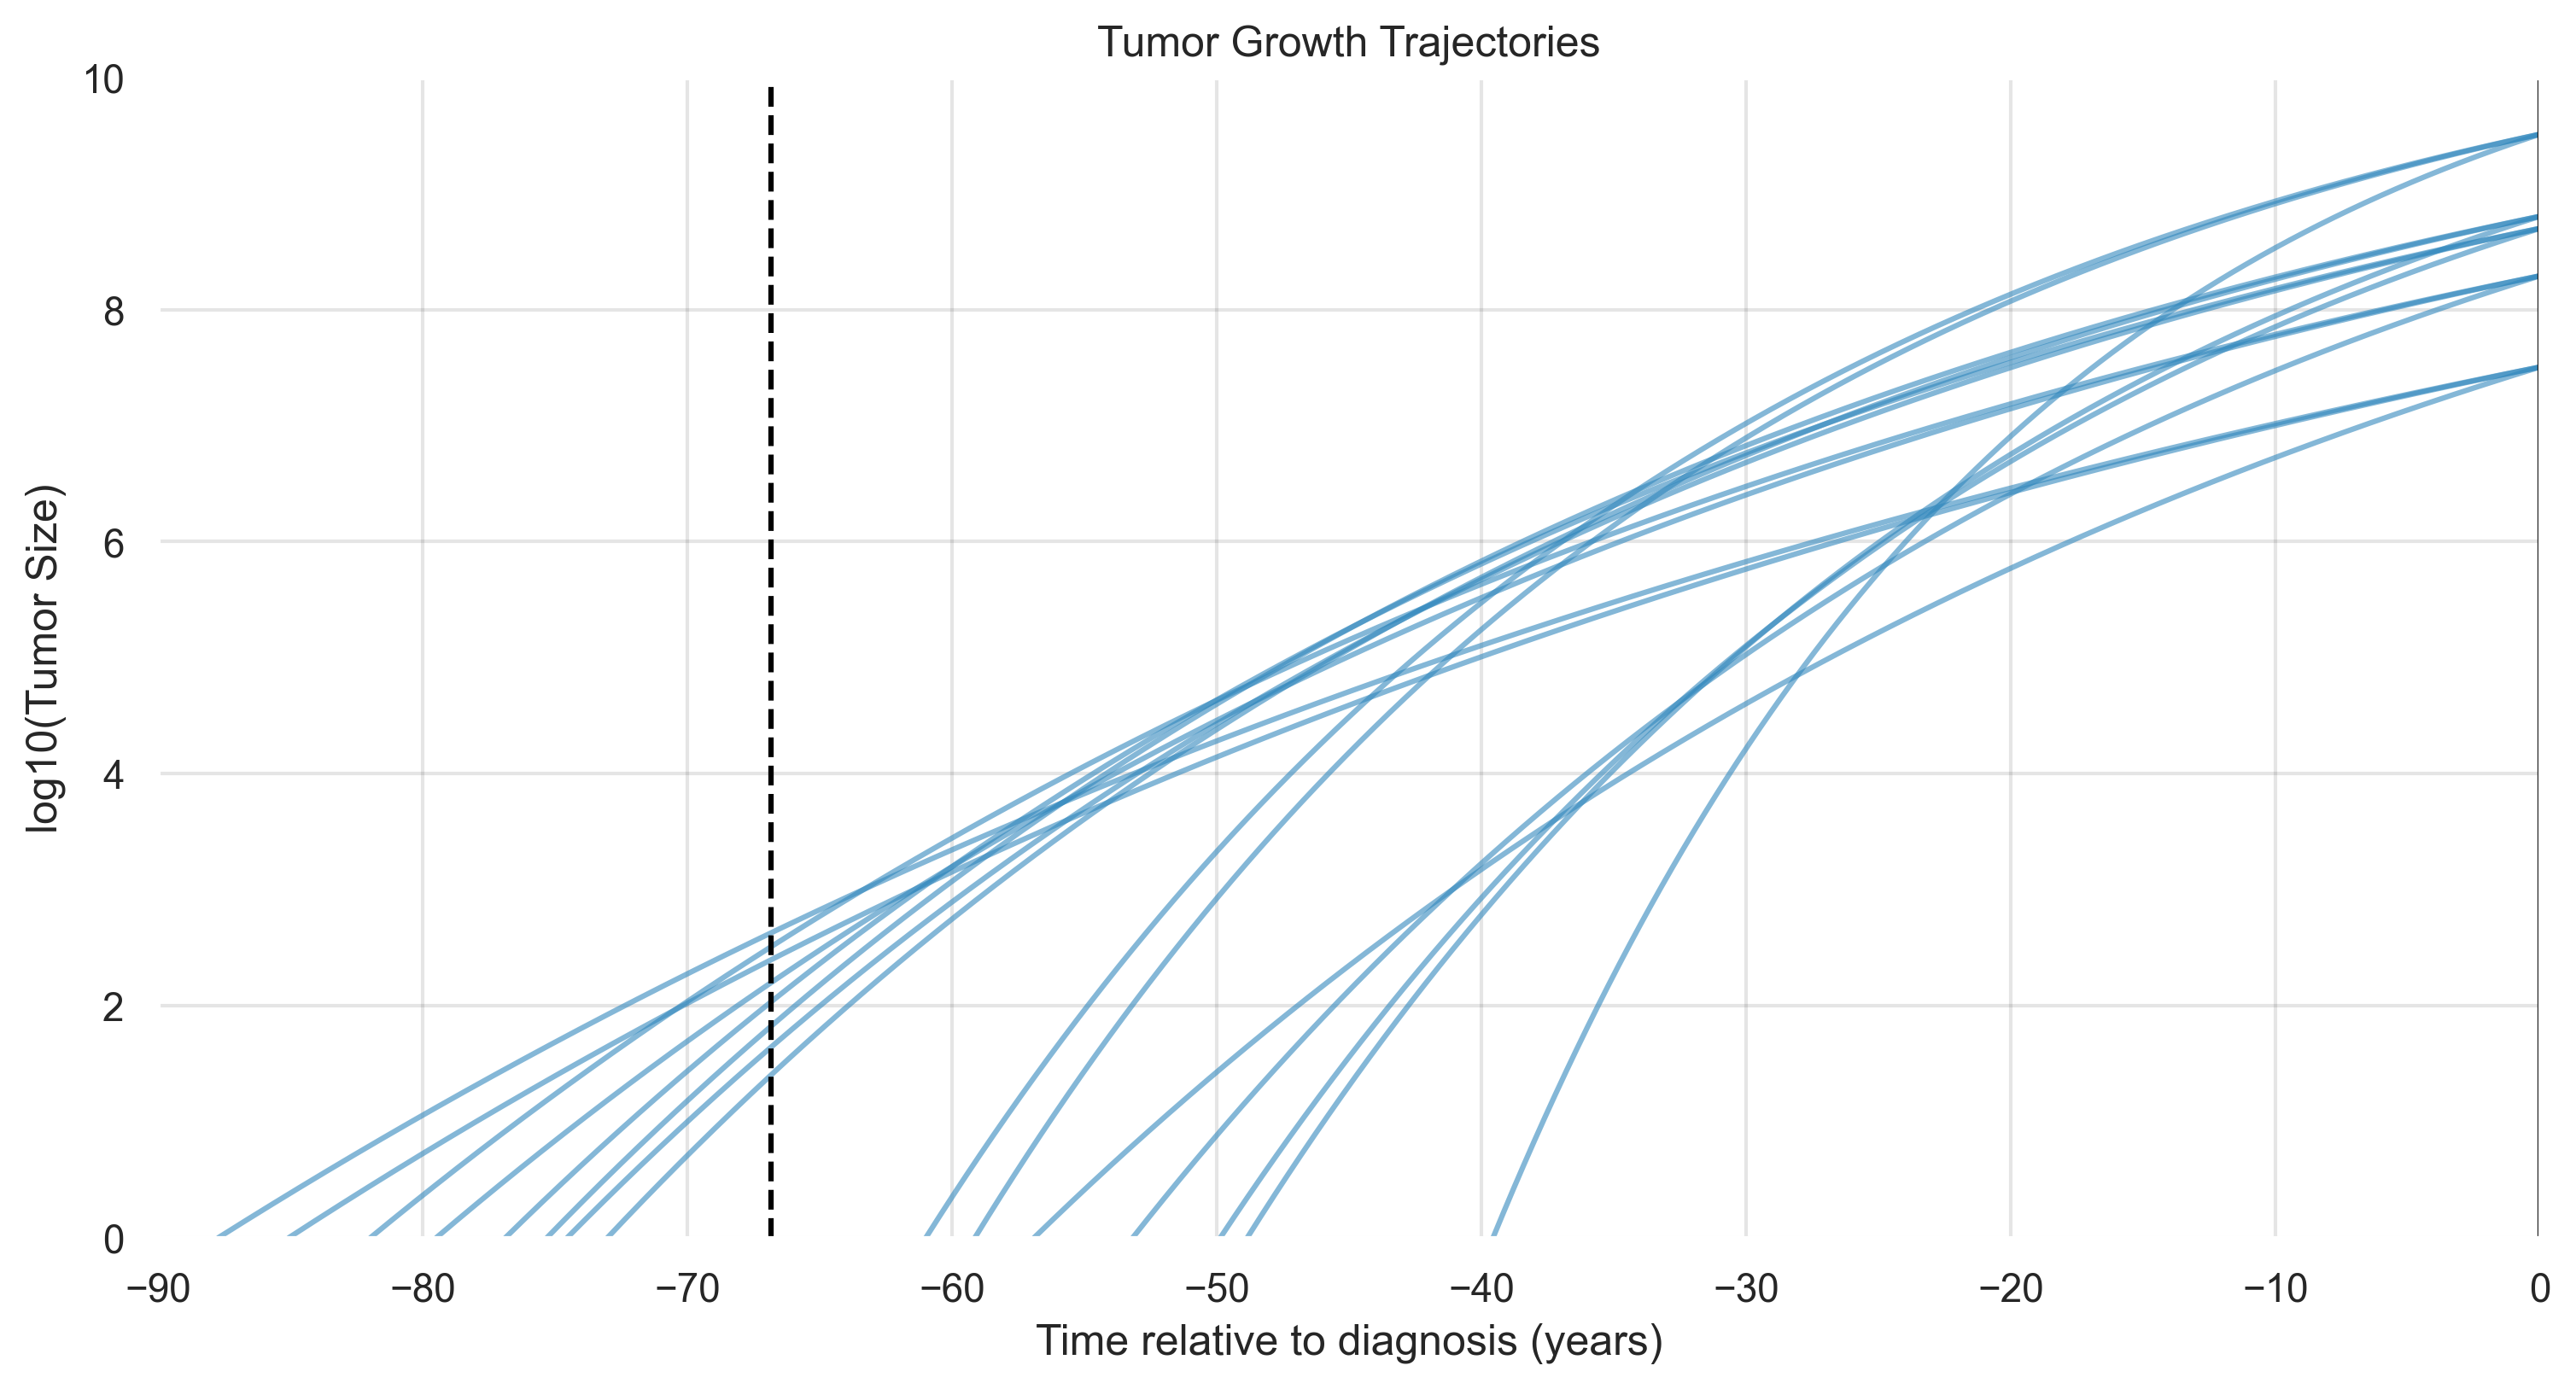

In [6]:
trajectories_weighted = calculate_trajectories(df_weighted)
trajectories_filtered = trajectories_weighted[trajectories_weighted['time_step2'] < 0]

# Plotting
plt.figure(figsize=(12, 6))

# Plot trajectories
for exp_age in df_weighted['age'].unique():
    mask = trajectories_filtered['exp_age'] == exp_age
    plt.plot(trajectories_filtered[mask]['time_step2'],
             np.log10(trajectories_filtered[mask]['St']),
             color='#3288bd', alpha=0.6)

plt.axvline(x=0, color='black', linestyle='-')
plt.axvline(x=df_weighted['age'].mean()*-1, color='black', linestyle='--')
plt.ylim(0, 10)
plt.xlim(-90, 0)

plt.title('Tumor Growth Trajectories')
plt.xlabel('Time relative to diagnosis (years)')
plt.ylabel('log10(Tumor Size)')

plt.grid(True, which='major', axis='both', color='black', alpha=0.1)
plt.show()

## 2. Modeling the Primary Tumor Expansion Age w/ Patient Level Data 

In [7]:
# Load the data
df = pd.read_excel("../../metadata/PPGL_doubling_time_estimates.xlsx", sheet_name='tumors')
df.head(10)

,study,patient_id,age,tumor_id,germline,tumor_size_t1,tumor_size_t2,vol_abs_change,vol_per_change,time_m,doubling_time_mo,doubling_time_yr
0,Michałowska,26,49.0,1,SDHD,0.020000,0.050000,0.03,150.0,10.0,7.564708,0.630392
1,Michałowska,26,49.0,2,SDHD,0.340681,0.510681,0.17,49.9,10.0,17.123276,1.426940
2,Michałowska,26,49.0,3,SDHD,6.009975,8.419975,2.41,40.1,10.0,20.556803,1.713067
3,Michałowska,26,49.0,4,SDHD,3.201320,4.171320,0.97,30.3,10.0,26.189180,2.182432
4,Michałowska,26,49.0,5,SDHD,0.152284,0.182284,0.03,19.7,10.0,38.547061,3.212255
5,Michałowska,26,49.0,6,SDHD,1.349481,0.959481,-0.39,-28.9,10.0,-20.321959,-1.693497
6,Michałowska,21,42.0,7,SDHD,0.588235,0.578235,-0.01,-1.7,10.0,-404.257996,-33.688166
7,Michałowska,21,42.0,8,SDHD,0.090090,0.070090,-0.02,-22.2,10.0,-27.612262,-2.301022
8,Michałowska,1,28.0,9,SDHB,0.829493,0.649493,-0.18,-21.7,13.0,-36.835983,-3.069665
9,Michałowska,5,25.0,10,SDHD,0.590219,0.940219,0.35,59.3,18.0,26.795832,2.232986


We have loaded data from **four** studies containing tumor-level data about the growth characteristics of pheochromocytomas and paragangliomas. The studies this data was extracted from include:
* Michałowska et al (2017). **PMID:** 27967220
* Wang et al (2016). **PMID:** 27073708
* Tooker et al (2023). **PMID:** 37590887
* Carlson et al (2015). **PMID:** 25361637

Let's begin with a quick exploratory analysis of the basic variables in the data.

In [8]:
df.groupby(['germline'])['germline'].count() # Distribution of germline mutations. 91 patients

germline
SDHB    17
SDHC     1
SDHD    67
WT       6
Name: germline, dtype: int64

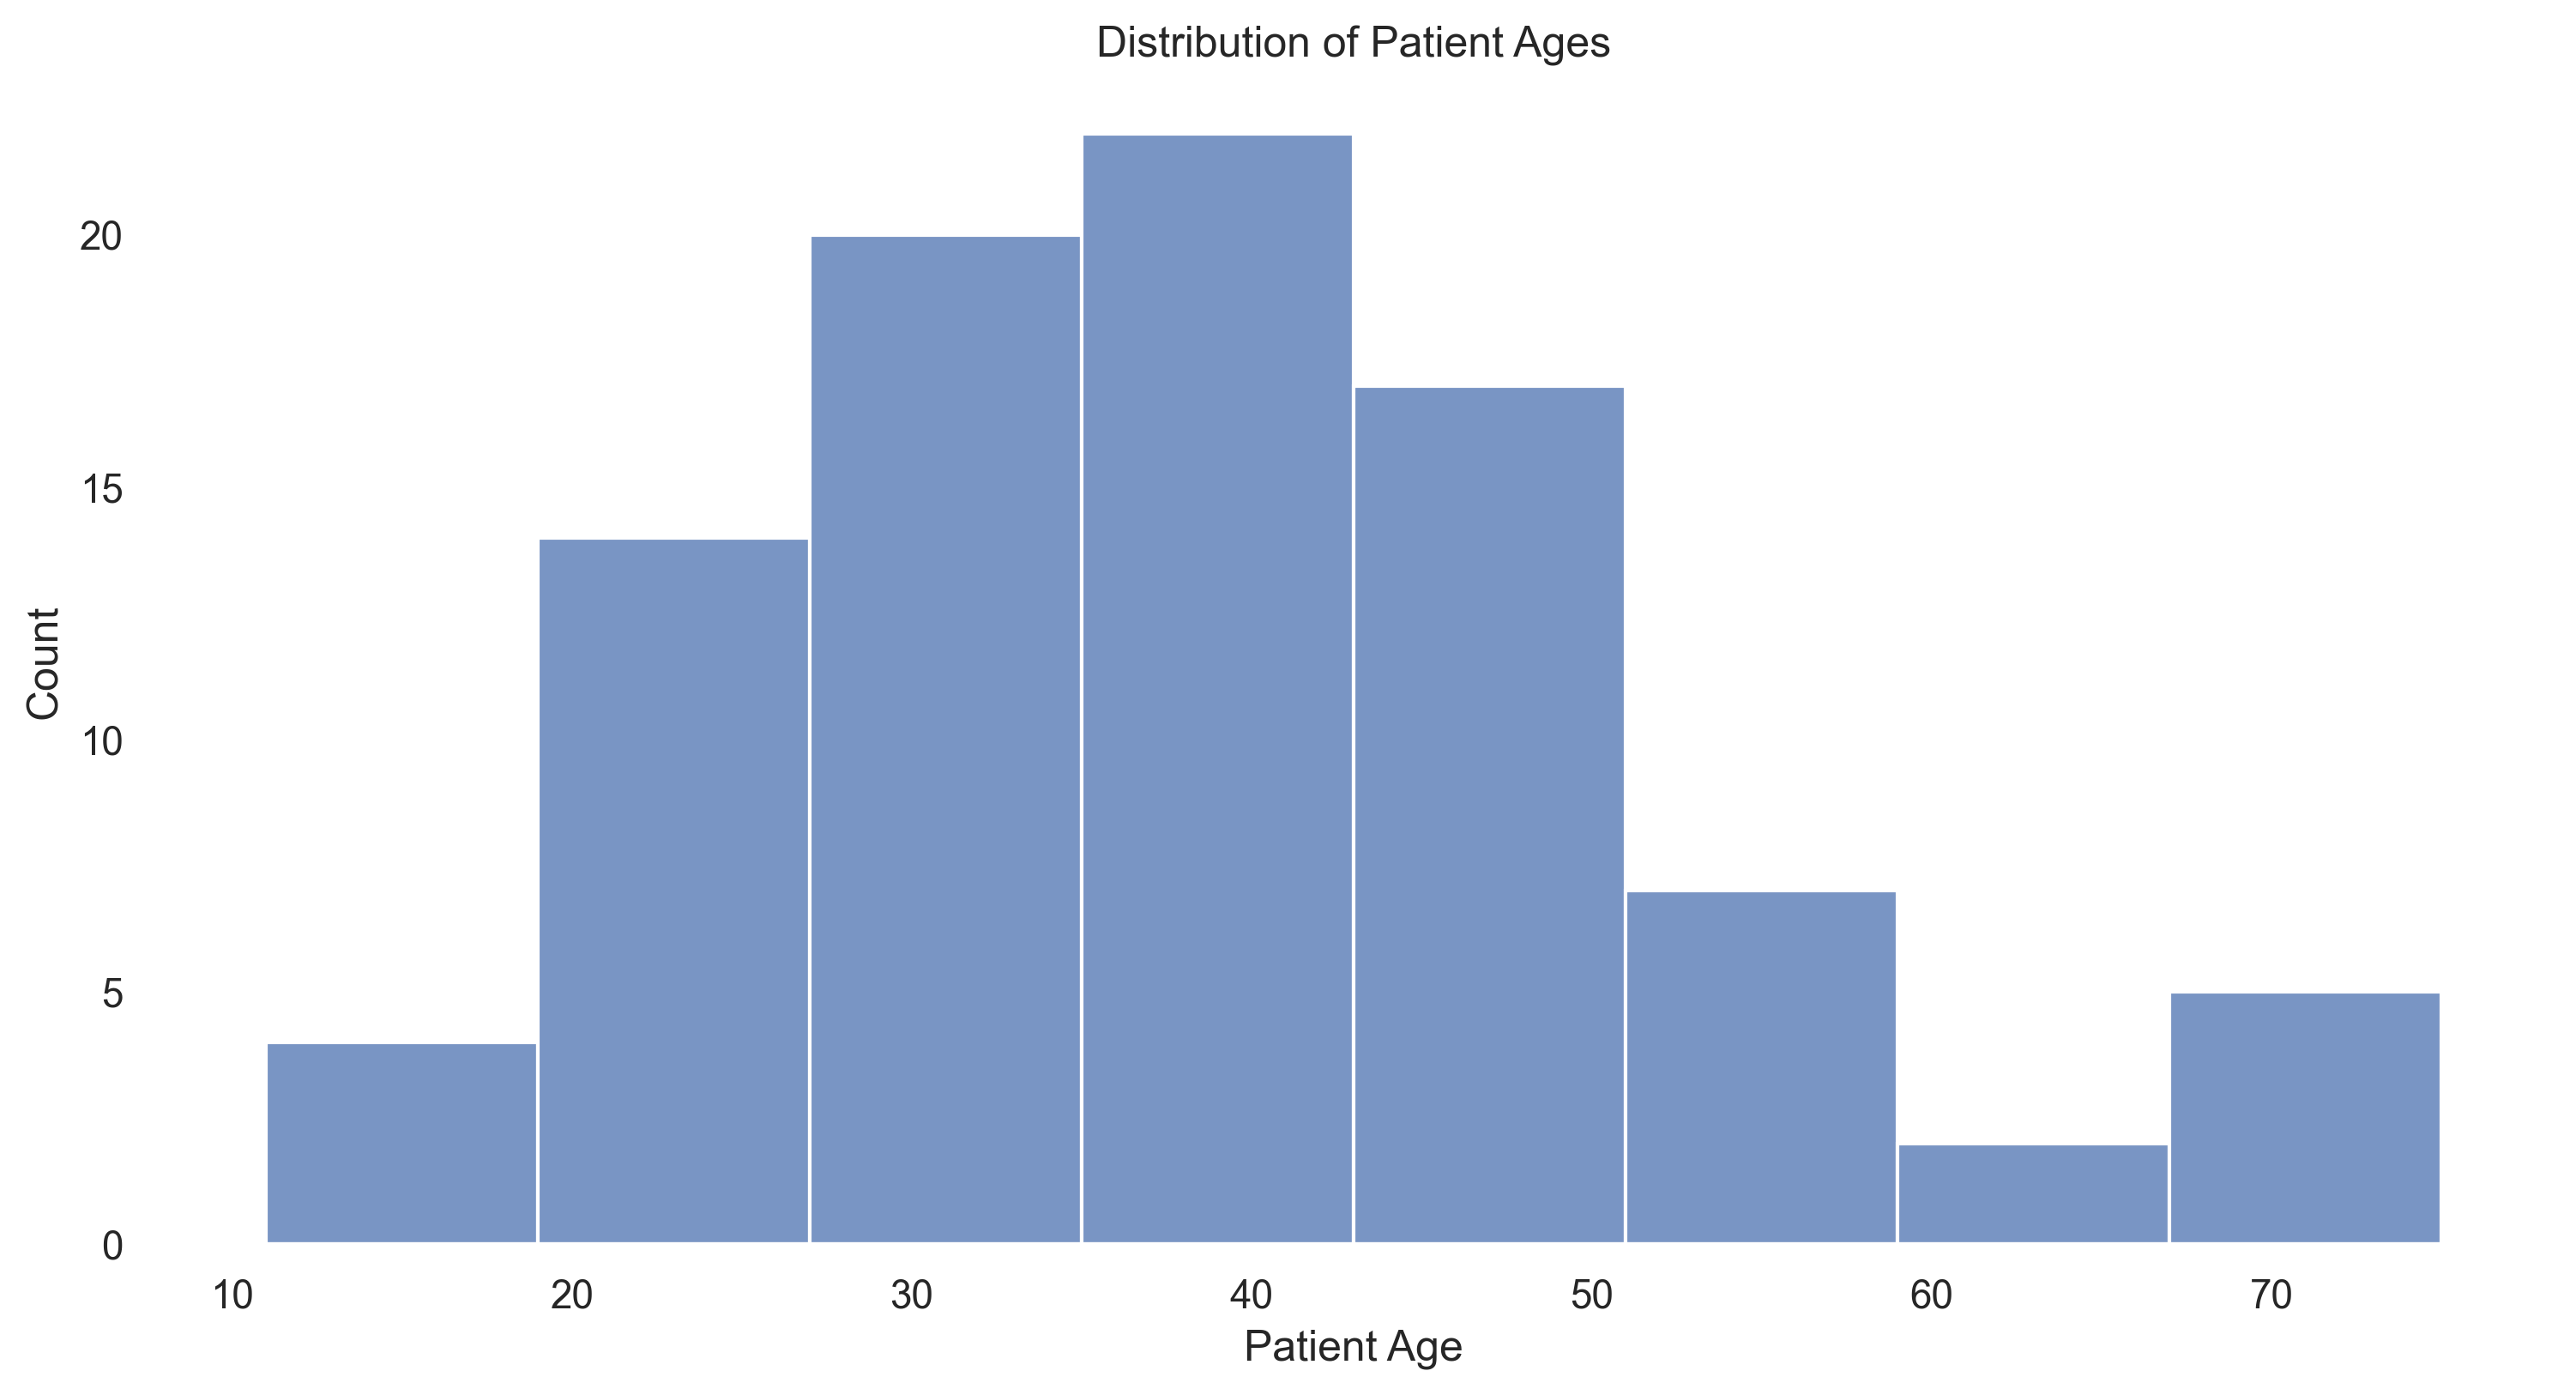

In [9]:
# Plot distrubtion of ages
plt.figure(figsize=(12, 6))
sns.histplot(df['age'])
plt.xlabel('Patient Age')
plt.ylabel('Count')
plt.title('Distribution of Patient Ages')
plt.grid(True)
plt.show()

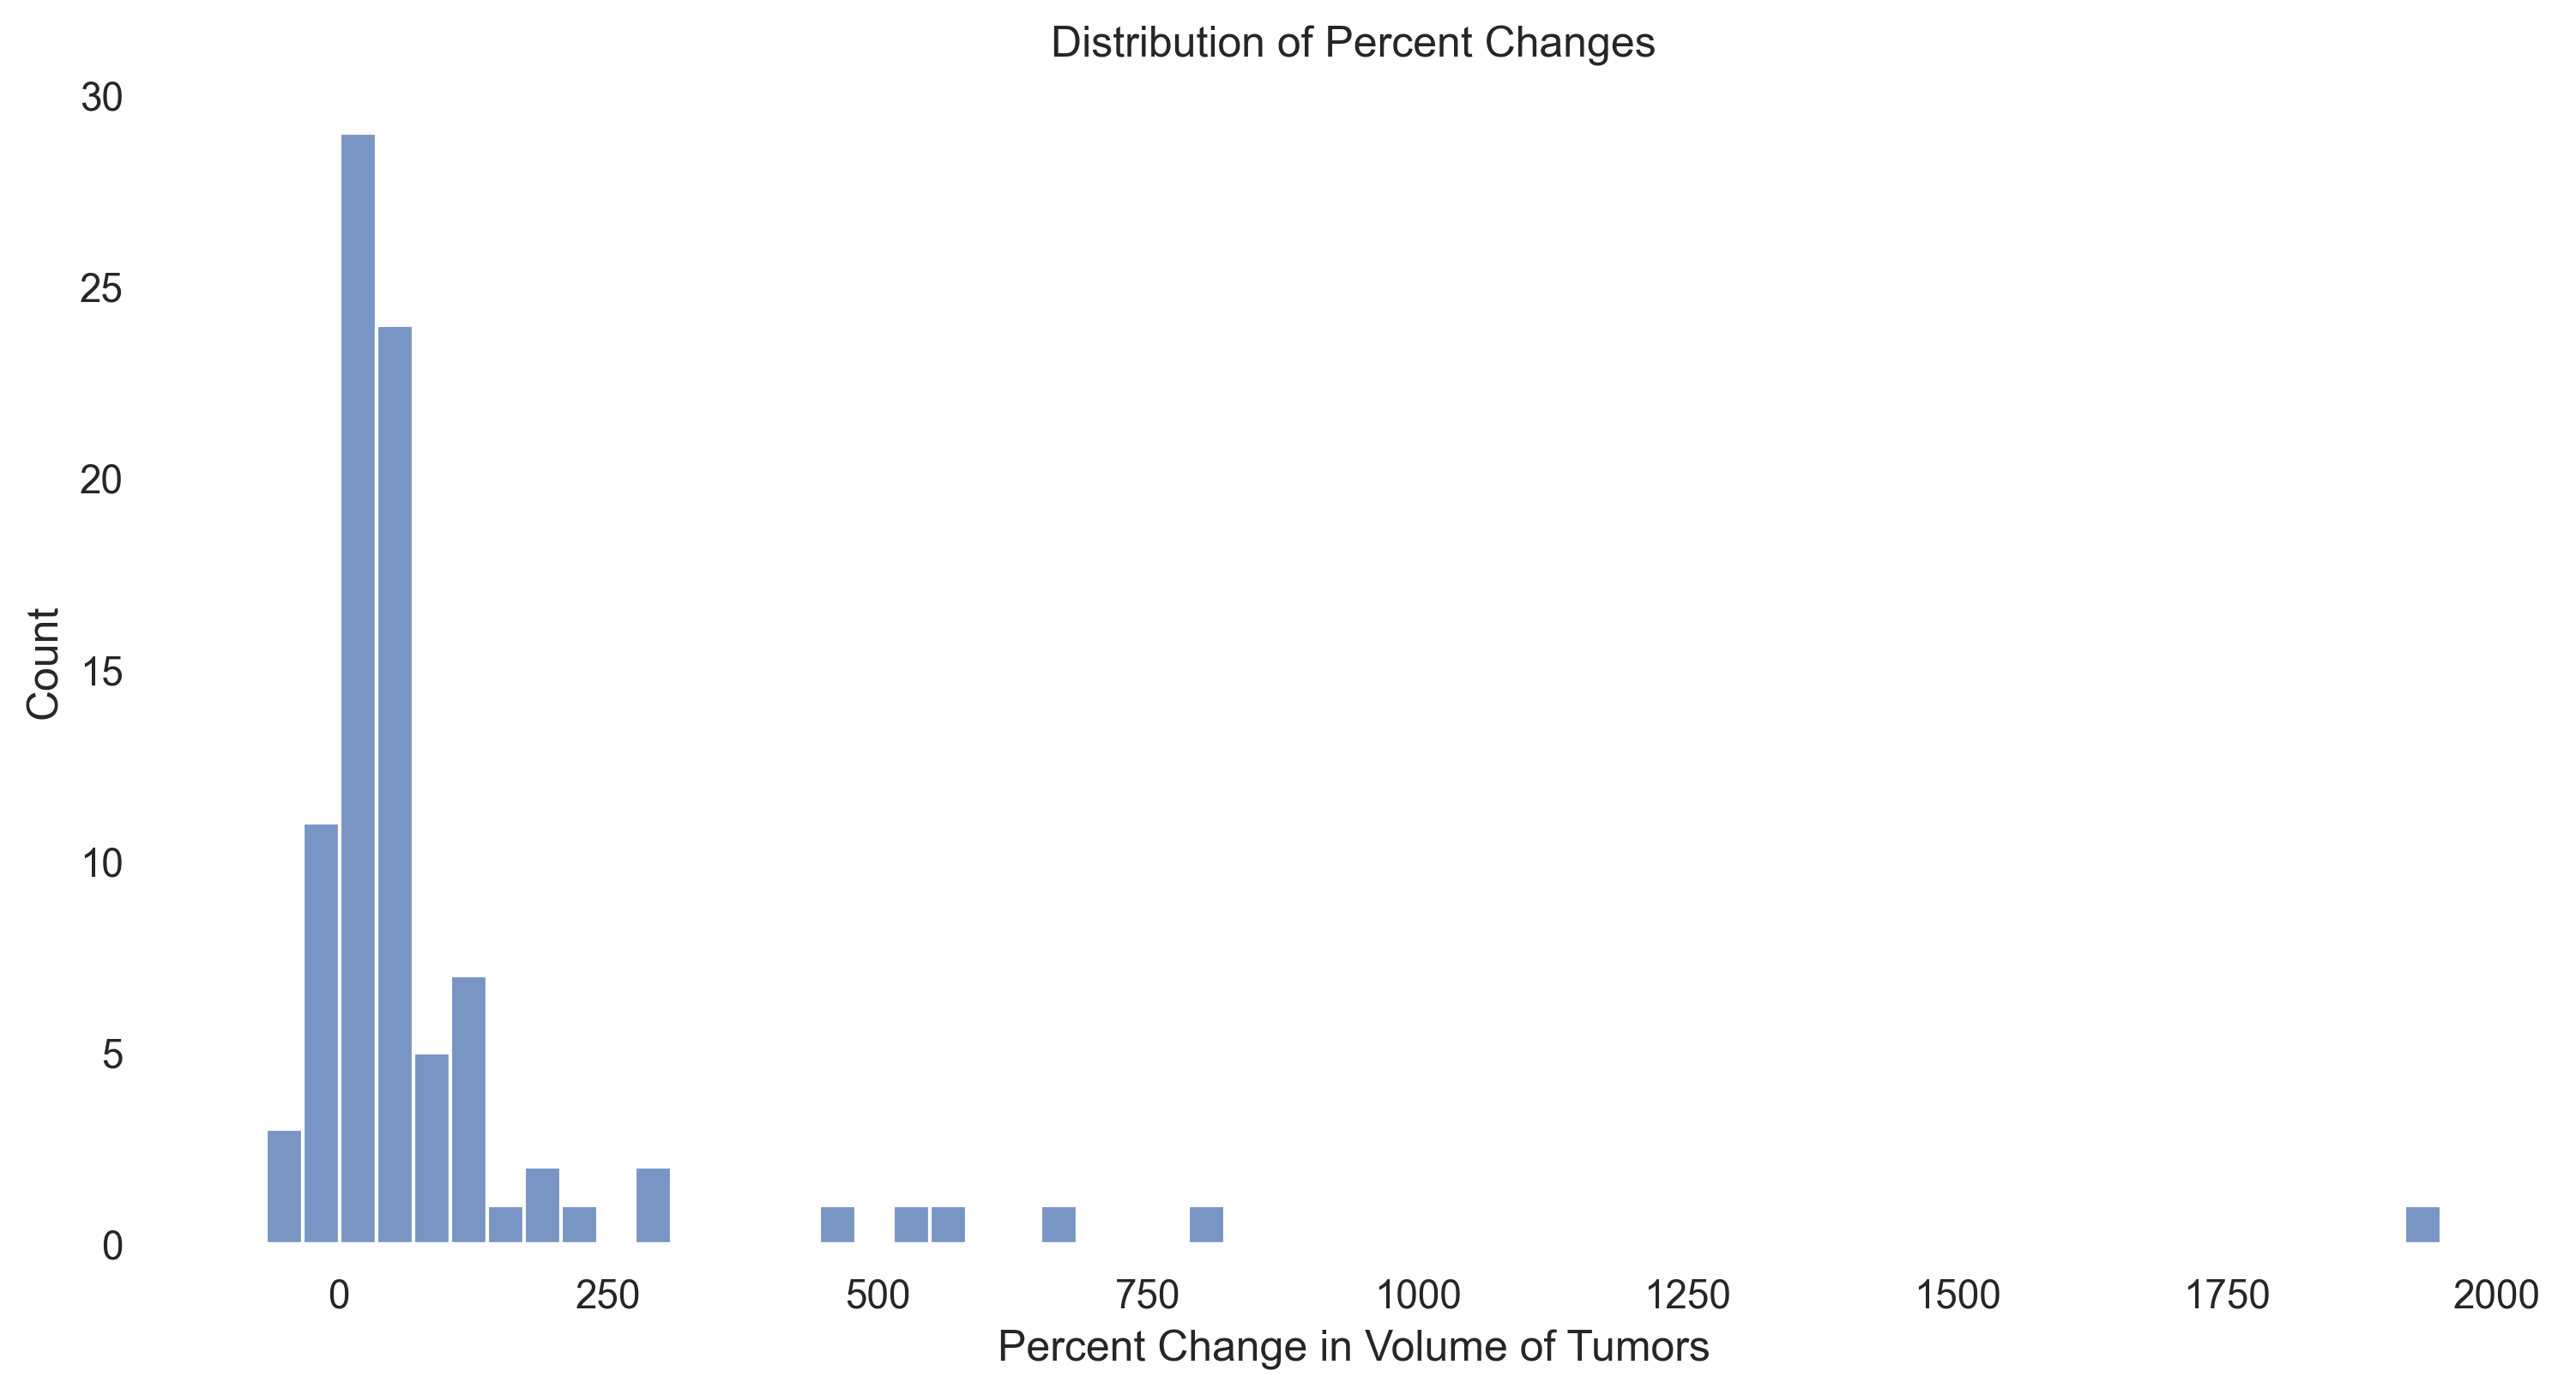

In [10]:
# Plot distribution of percent volume growth
plt.figure(figsize=(12, 6))
sns.histplot(df['vol_per_change'])
plt.xlabel('Percent Change in Volume of Tumors')
plt.ylabel('Count')
plt.title('Distribution of Percent Changes')
plt.grid(True)
plt.show()

We can see that several patients have no growth or negative growth over their study period. These patients will have to be excluded from further analysis.

In [11]:
print(len(df[df['vol_per_change'] > 0.0]), " patients have growth during their study periods")
print(len(df[df['vol_per_change'] < 0.0]), " patients have no growth or negative growth during their study periods")

77  patients have growth during their study periods
14  patients have no growth or negative growth during their study periods


In [12]:
df = df[df['vol_per_change'] > 0.0]
df.groupby(['germline'])['germline'].count() # Distribution of germline mutations

germline
SDHB    15
SDHC     1
SDHD    55
WT       6
Name: germline, dtype: int64

## 2. Implement Analysis Utilized by Hu et al (Nature Genetics 2020)

In [ ]:
def calculate_primary_tumor_expansion_age(row):
    """Implement the original model calculations"""
    log_limit_size = np.log(1e11)
    dx_size = row['tumor_size_t1'] * 1e8
    doubling_time_days = row['doubling_time_yr'] * 365
    
    try:
        beta = 1/doubling_time_days * np.log(
            (log_limit_size - np.log(dx_size)) / 
            (log_limit_size - np.log(2 * dx_size))
        )
        alpha = log_limit_size * beta
        exp_age = -1/beta * np.log(1 - np.log(dx_size) * beta / alpha) / 365
        
        return pd.Series({
            'beta': beta,
            'alpha': alpha,
            'exp_age': exp_age,
            'plausible': (exp_age > 0) & (exp_age < row['age']) # Tumor should be younger than patient
        })
    except:
        return pd.Series({
            'beta': np.nan,
            'alpha': np.nan,
            'exp_age': np.nan,
            'plausible': False
        })

In [ ]:
# Apply Hu et al model
original_results = df.apply(calculate_primary_tumor_expansion_age, axis=1)
df = pd.concat([df, original_results], axis=1)
df.head(10)

,study,patient_id,age,tumor_id,germline,tumor_size_t1,tumor_size_t2,vol_abs_change,vol_per_change,time_m,doubling_time_mo,doubling_time_yr,beta,alpha,exp_age,plausible
0,Michałowska,26,49.0,1,SDHD,0.020000,0.050000,0.03,150.0,10.0,7.564708,0.630392,0.000288,0.007288,8.098550,True
1,Michałowska,26,49.0,2,SDHD,0.340681,0.510681,0.17,49.9,10.0,17.123276,1.426940,0.000174,0.004416,18.139439,True
2,Michałowska,26,49.0,3,SDHD,6.009975,8.419975,2.41,40.1,10.0,20.556803,1.713067,0.000233,0.005900,18.818465,True
3,Michałowska,26,49.0,4,SDHD,3.201320,4.171320,0.97,30.3,10.0,26.189180,2.182432,0.000161,0.004089,25.181223,True
4,Michałowska,26,49.0,5,SDHD,0.152284,0.182284,0.03,19.7,10.0,38.547061,3.212255,0.000070,0.001774,41.387785,True
9,Michałowska,5,25.0,10,SDHD,0.590219,0.940219,0.35,59.3,18.0,26.795832,2.232986,0.000120,0.003041,27.967825,False
11,Michałowska,24,30.0,12,SDHD,6.964286,7.354286,0.39,5.6,20.0,254.421092,21.201758,0.000019,0.000492,229.805920,False
12,Michałowska,25,46.0,13,SDHD,0.296482,1.956482,1.66,559.9,23.0,8.448901,0.704075,0.000347,0.008790,8.977142,True
13,Michałowska,25,46.0,14,SDHD,1.562500,1.662500,0.10,6.4,23.0,256.988550,21.415712,0.000015,0.000368,257.812333,False
14,Michałowska,25,46.0,15,SDHD,0.172414,0.182414,0.01,5.8,23.0,282.765003,23.563750,0.000010,0.000246,303.154720,False


In [15]:
# Analyze results
print("Original Model Results:")
print(f"Total cases: {len(df)}")
print(f"Plausible estimates: {df['plausible'].sum()}")
print(f"Implausible estimates: {len(df) - df['plausible'].sum()}")

Original Model Results:
Total cases: 77
Plausible estimates: 23
Implausible estimates: 54


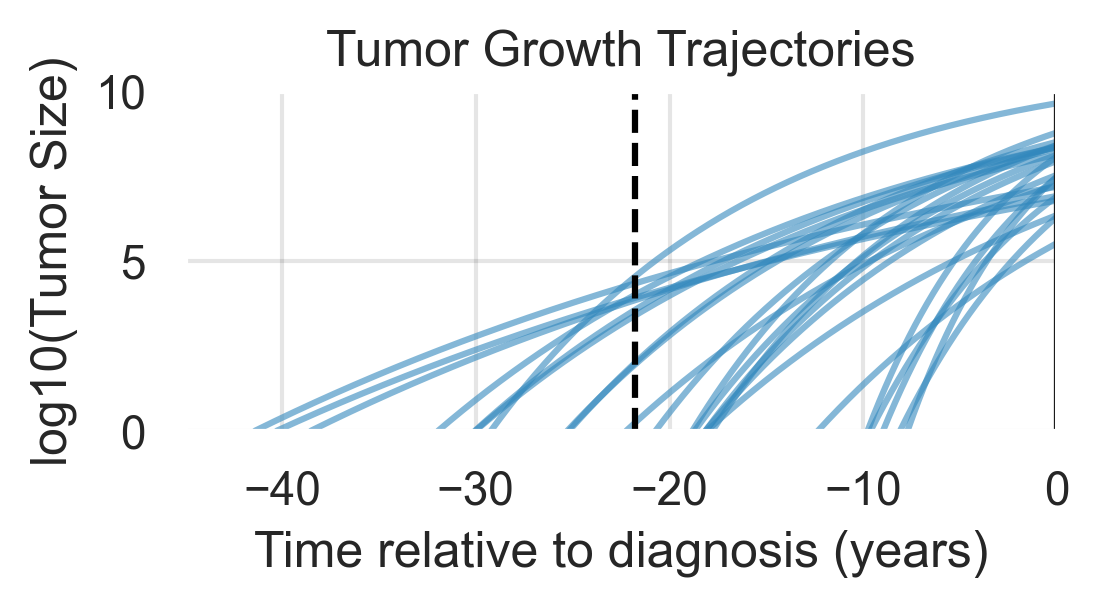

In [16]:
trajectories_weighted = calculate_trajectories(df[df['plausible'] == True], age_col='exp_age')
trajectories_filtered = trajectories_weighted[trajectories_weighted['time_step2'] < 0]

# Plotting
plt.figure(figsize=(3.75, 1.5))

# Plot trajectories
for exp_age in df['exp_age'].unique():
    mask = trajectories_filtered['exp_age'] == exp_age
    plt.plot(trajectories_filtered[mask]['time_step2'],
             np.log10(trajectories_filtered[mask]['St']),
             color='#3288bd', alpha=0.6)

plt.axvline(x=0, color='black', linestyle='-')
plt.axvline(x=df[df['plausible'] == True]['exp_age'].mean()*-1, color='black', linestyle='--')
plt.ylim(0, 10)
plt.xlim(-45, 0)

plt.title('Tumor Growth Trajectories')
plt.xlabel('Time relative to diagnosis (years)')
plt.ylabel('log10(Tumor Size)')
plt.grid(True, which='major', axis='both', color='black', alpha=0.1)
plt.show()

In [17]:
def analyze_sensitivity(df, growth_rate_thresholds):
    """Analyze model sensitivity to different growth rate thresholds"""
    results = []
    
    for threshold in growth_rate_thresholds:
        # Apply threshold
        mask = df['monthly_growth_rate'] >= threshold
        filtered_df = df[mask]
        
        # Calculate metrics
        n_plausible = filtered_df['plausible'].sum()
        n_total = len(filtered_df)
        
        results.append({
            'threshold': threshold,
            'n_cases': n_total,
            'n_plausible': n_plausible,
            'plausible_ratio': n_plausible/n_total if n_total > 0 else 0
        })
    
    return pd.DataFrame(results)

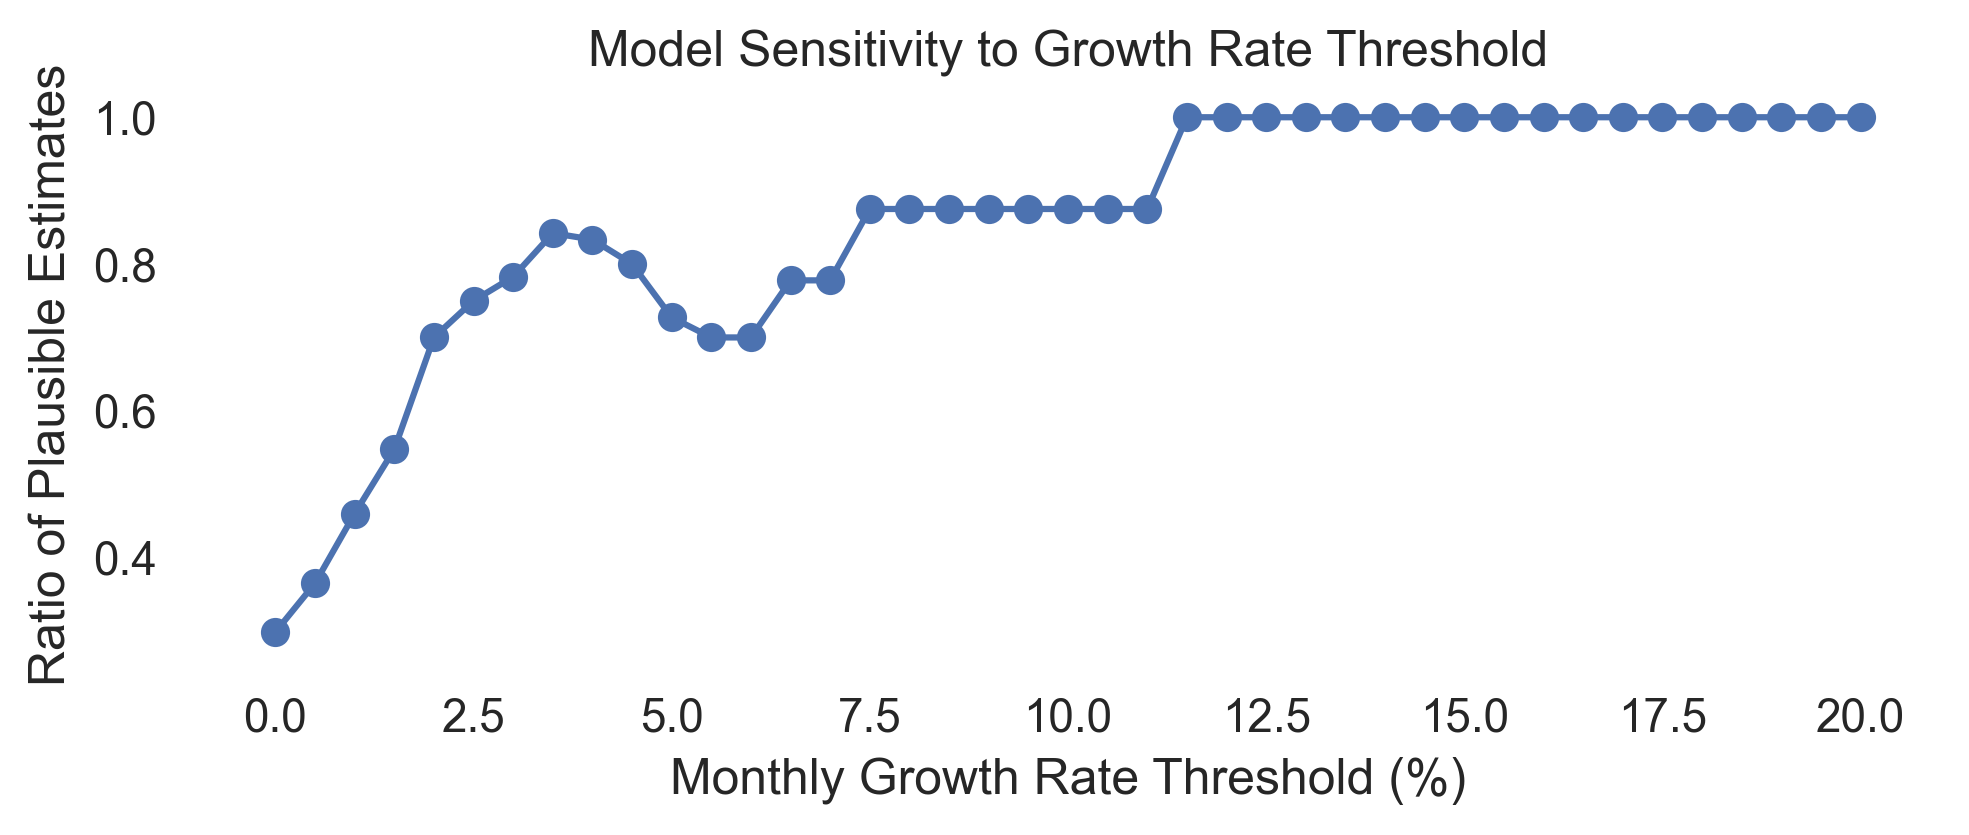

In [18]:
# Define thresholds to test
thresholds = np.linspace(0, 20, 41)  # 0% to 10% monthly growth rate
df['monthly_growth_rate'] = df['vol_per_change'] / df['time_m']

# Run sensitivity analysis
sensitivity_results = analyze_sensitivity(df, thresholds)

# Plot results
plt.figure(figsize=(7.5, 2.5))
plt.plot(sensitivity_results['threshold'], sensitivity_results['plausible_ratio'], 'o-')
plt.xlabel('Monthly Growth Rate Threshold (%)')
plt.ylabel('Ratio of Plausible Estimates')
plt.title('Model Sensitivity to Growth Rate Threshold')
plt.grid(True)
plt.savefig("../../results/figures/mutational_timing/hu_sensitivity_growth_rate.pdf")
plt.show()

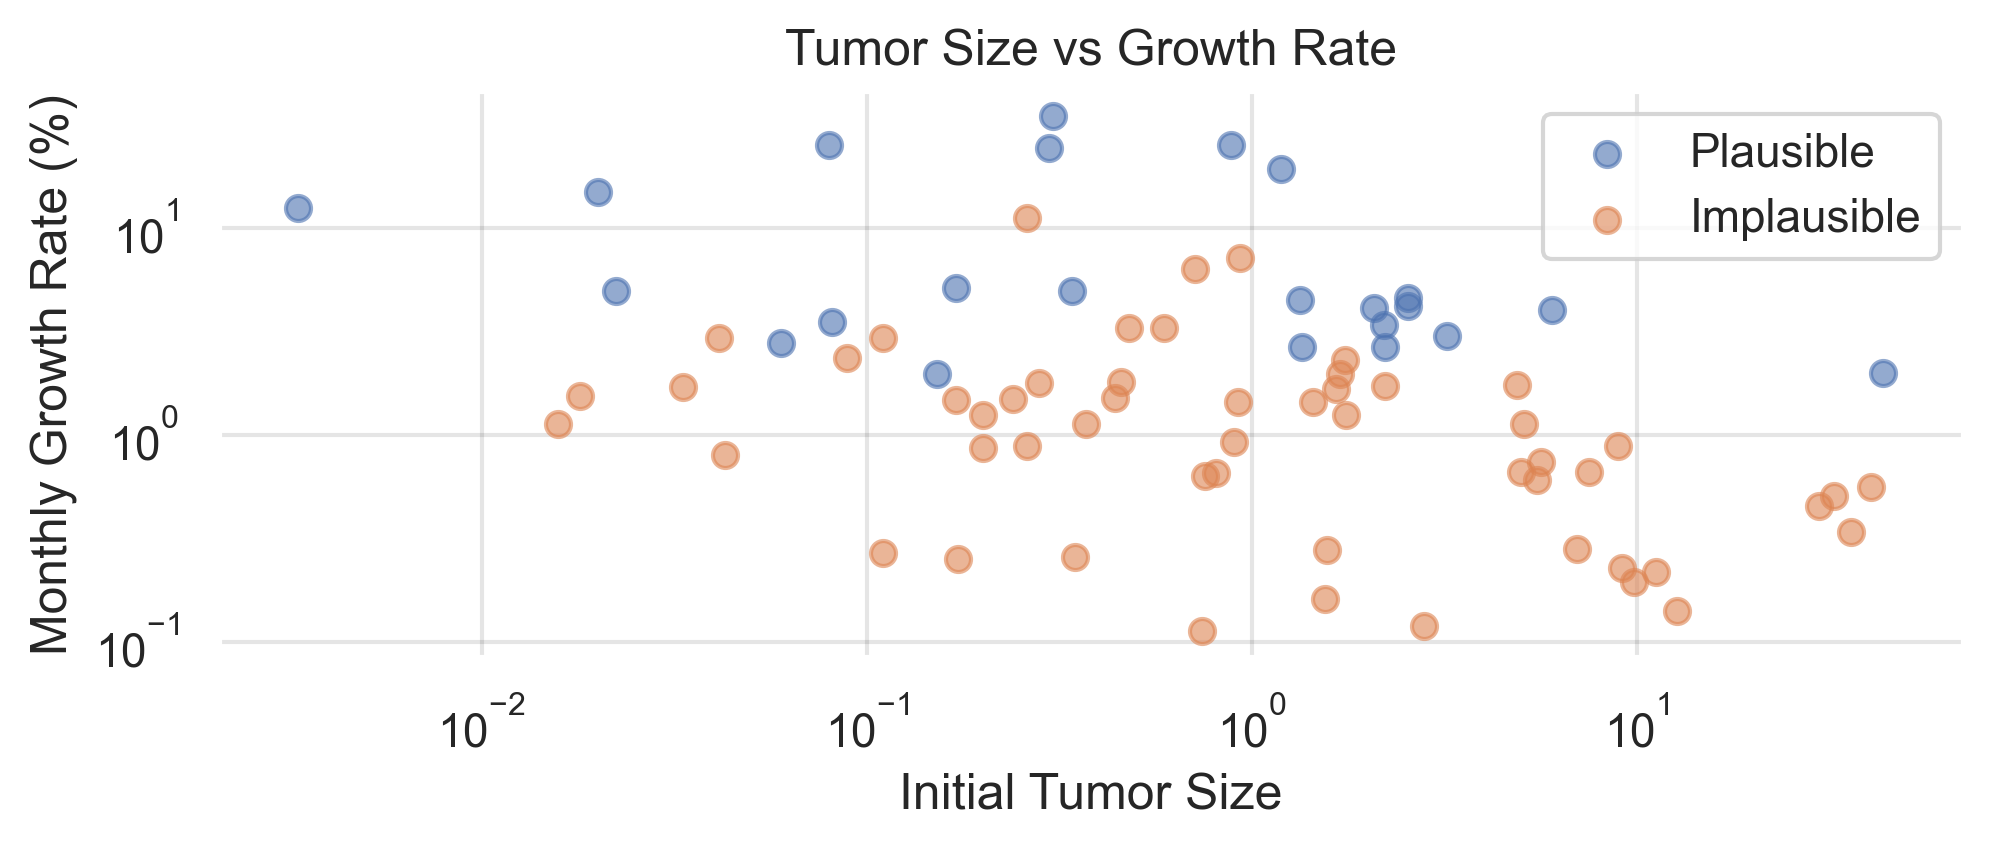

In [19]:
# 1. Relationship between tumor size and model plausibility
plt.figure(figsize=(7.5, 2.5))
plt.scatter(df[df['plausible']]['tumor_size_t1'], 
           df[df['plausible']]['monthly_growth_rate'],
           label='Plausible', alpha=0.6)
plt.scatter(df[~df['plausible']]['tumor_size_t1'], 
           df[~df['plausible']]['monthly_growth_rate'],
           label='Implausible', alpha=0.6)
plt.xlabel('Initial Tumor Size')
plt.ylabel('Monthly Growth Rate (%)')
plt.title('Tumor Size vs Growth Rate')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True, which='major', color='black', alpha=0.1)
plt.savefig("../../results/figures/mutational_timing/hu_tumor_size_plausibility.pdf")
plt.show()

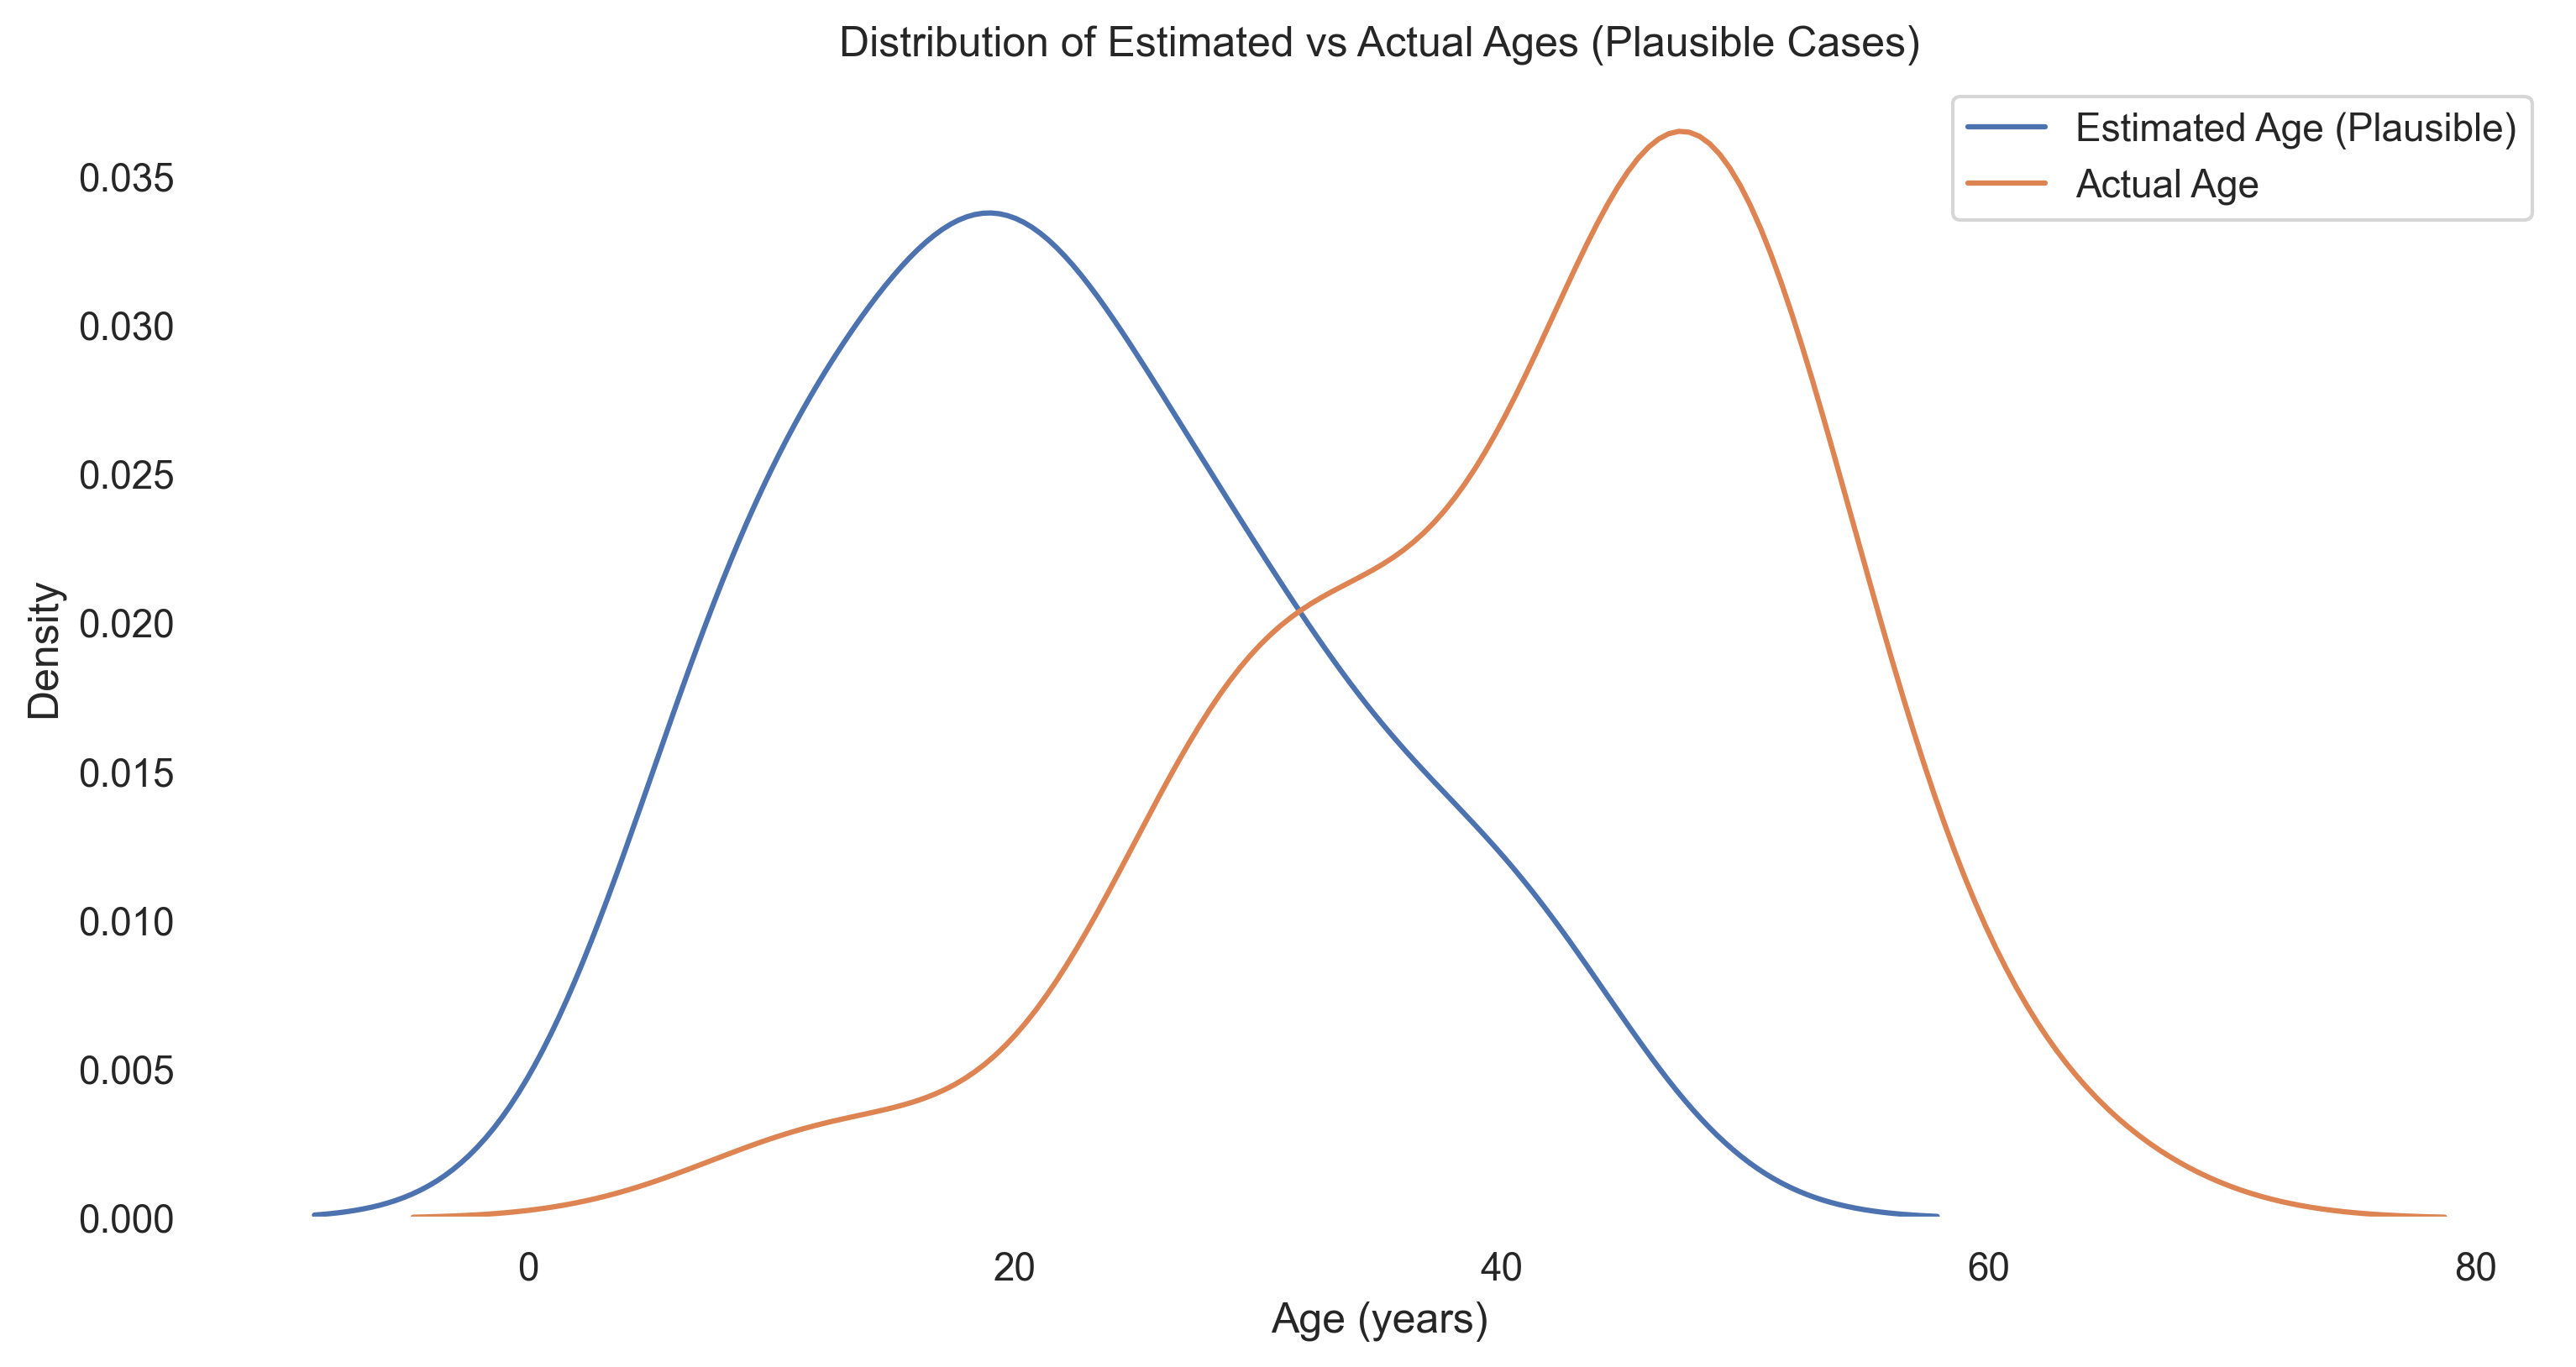

In [20]:
# 2. Age distribution analysis
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df[df['plausible']], x='exp_age', label='Estimated Age (Plausible)')
sns.kdeplot(data=df[df['plausible']], x='age', label='Actual Age')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Estimated vs Actual Ages (Plausible Cases)')
plt.legend()
plt.show()

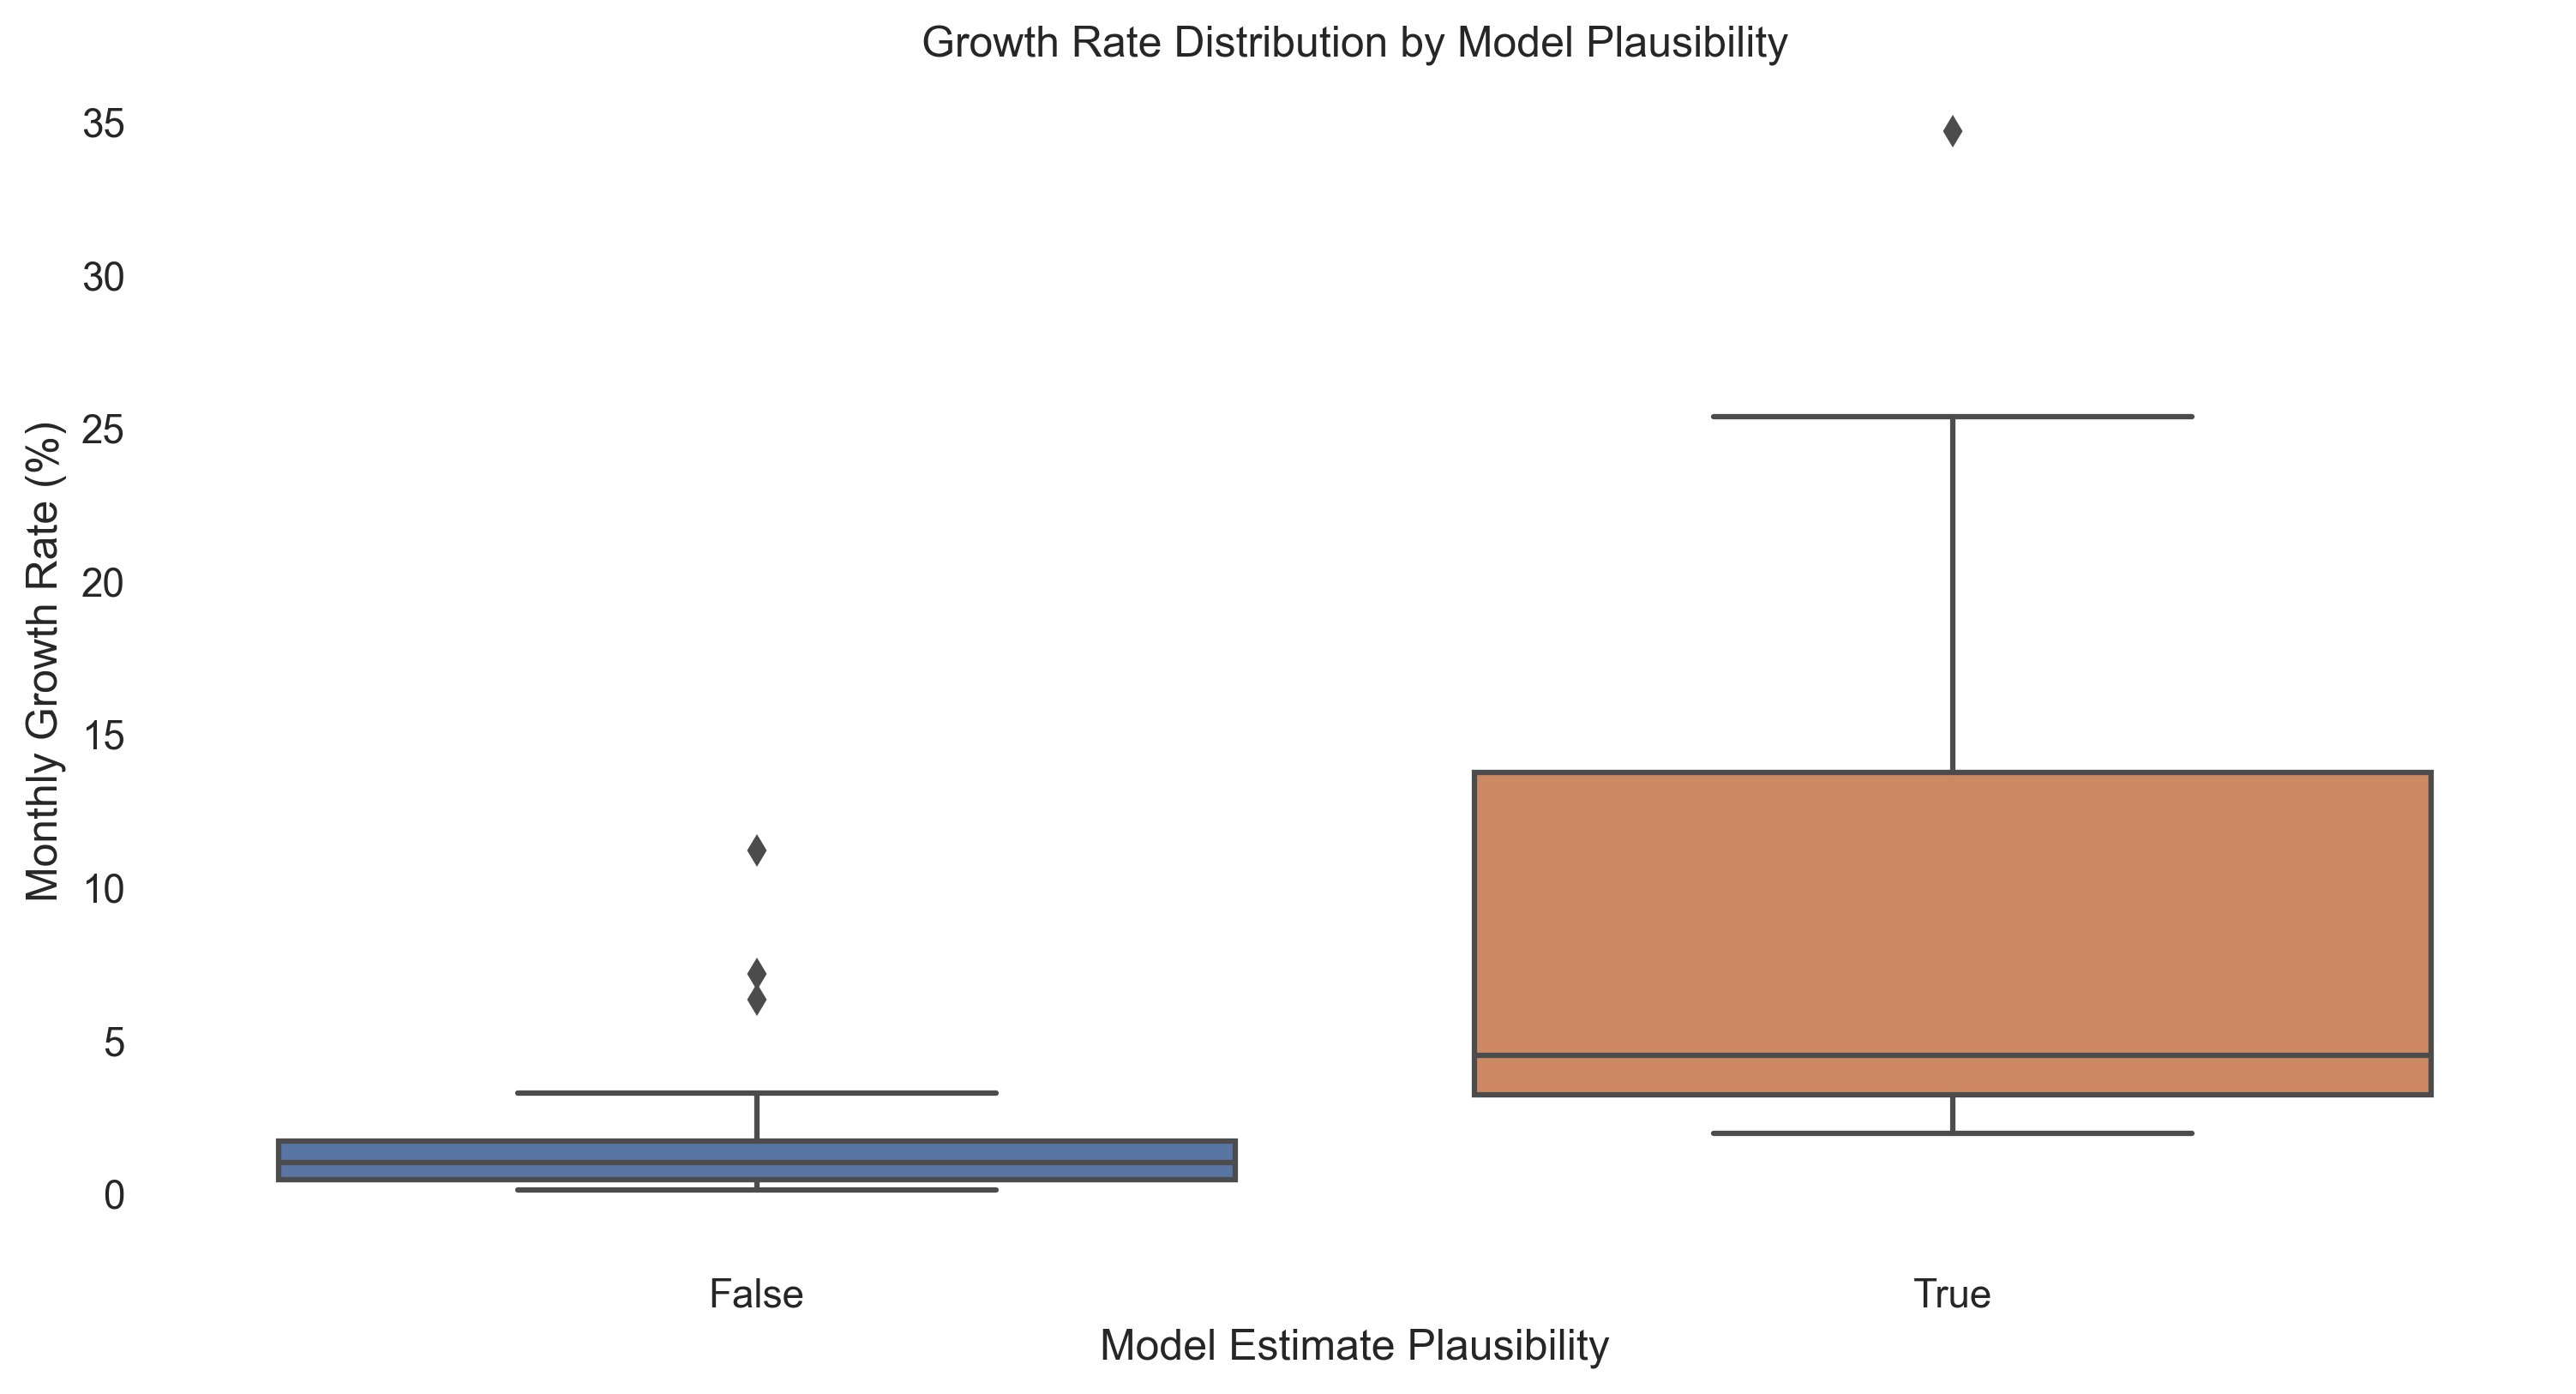

In [21]:
# 3. Growth rate distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='plausible', y='monthly_growth_rate', data=df)
plt.xlabel('Model Estimate Plausibility')
plt.ylabel('Monthly Growth Rate (%)')
plt.title('Growth Rate Distribution by Model Plausibility')
plt.show()

## 3. Alternative Model Implementation
This modeul will directly account for tumor size and growth rate which seem to be major contributors to poor model fit in the original Hu et al model. This is not unexpected as their model was fit to Colon, Breast, and Lung cancer which are more aggressive/rapidly growing than relatively indolent PCC/PGL.

In [22]:
df = pd.read_excel("../../metadata/PPGL_doubling_time_estimates.xlsx", sheet_name='tumors')
df = df[df['vol_per_change'] > 0.0]

In [23]:
def calculate_primary_tumor_expansion_age_adjusted(row):
    """Implement the improved model calculations"""
    log_limit_size = np.log(1e11)
    dx_size = row['tumor_size_t1'] * 1e8
    doubling_time_days = row['doubling_time_yr'] * 365
    
    try:
        # Calculate monthly growth rate
        monthly_growth_rate = row['vol_per_change'] / row['time_m']
        
        # Calculate base growth rate
        base_beta = np.log(2) / doubling_time_days
        
        # Adjust beta based on current growth rate and tumor size
        growth_factor = 1 - np.log(dx_size) / log_limit_size
        beta_adj = base_beta * growth_factor * (1 + monthly_growth_rate/100)
        
        # Calculate modified alpha
        alpha_adj = log_limit_size * beta_adj
        
        # Calculate expected age
        exp_age_adj = -1/beta_adj * np.log(1 - np.log(dx_size) * beta_adj / alpha_adj) / 365
        exp_age_adj = max(0, exp_age_adj)
        
        return pd.Series({
            'monthly_growth_rate': monthly_growth_rate,
            'beta': beta_adj,
            'alpha': alpha_adj,
            'exp_age': exp_age_adj,
            'plausible': (exp_age_adj > 0) & (exp_age_adj < row['age'])
        })
    except:
        return pd.Series({
            'monthly_growth_rate': np.nan,
            'beta': np.nan,
            'alpha': np.nan,
            'exp_age': np.nan,
            'plausible': False
        })

In [ ]:
# Apply new model
results = df.apply(calculate_primary_tumor_expansion_age_adjusted, axis=1)
df = pd.concat([df, results], axis=1)

# Compare results
print("Improved Model Results:")
print(f"Total cases: {len(df)}")
print(f"Plausible estimates: {df['plausible'].sum()}")
print(f"Implausible estimates: {len(df) - df['plausible'].sum()}")

Improved Model Results:
Total cases: 77
Plausible estimates: 44
Implausible estimates: 33


In [26]:
print(np.median(df[df['plausible'] == True]['exp_age']))
print(np.percentile(df[df['plausible'] == True]['exp_age'], 25))
print(np.percentile(df[df['plausible'] == True]['exp_age'], 75))

13.944244695017858
8.727792356923047
21.083973774325386


In [ ]:
trajectories_weighted = calculate_trajectories(df[df['plausible'] == True], age_col='exp_age')
trajectories_filtered = trajectories_weighted[trajectories_weighted['time_step2'] < 0]

# Plotting
plt.figure(figsize=(12, 6))

# Plot trajectories
for exp_age in df['exp_age'].unique():
    mask = trajectories_filtered['exp_age'] == exp_age
    plt.plot(trajectories_filtered[mask]['time_step2'],
             np.log10(trajectories_filtered[mask]['St']),
             color='#3288bd', alpha=0.6)

plt.axvline(x=0, color='black', linestyle='-')
plt.axvline(x=df[df['plausible'] == True]['exp_age'].mean()*-1, color='black', linestyle='--')
plt.ylim(0, 10)

plt.title('Tumor Growth Trajectories')
plt.xlabel('Time relative to diagnosis (years)')
plt.ylabel('log10(Tumor Size)')

plt.grid(True, which='major', axis='both', color='black', alpha=0.1)
plt.savefig("../../results/figures/mutational_timing/primary_tumor_expansion_age.pdf")
plt.show()

In [ ]:
df[df['plausible'] == True]['exp_age'].mean()

## 4. Sensitivity Analysis

In [ ]:
# Define thresholds to test
thresholds = np.linspace(0, 20, 41)  # 0% to 10% monthly growth rate
df['monthly_growth_rate'] = df['vol_per_change'] / df['time_m']

# Run sensitivity analysis
sensitivity_results = analyze_sensitivity(df, thresholds)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(sensitivity_results['threshold'], sensitivity_results['plausible_ratio'], 'o-')
plt.xlabel('Monthly Growth Rate Threshold (%)')
plt.ylabel('Ratio of Plausible Estimates')
plt.title('Model Sensitivity to Growth Rate Threshold')
plt.grid(True)
plt.show()

In [ ]:
# 1. Relationship between tumor size and model plausibility
plt.figure(figsize=(12, 6))
plt.scatter(df[df['plausible']]['tumor_size_t1'], 
           df[df['plausible']]['monthly_growth_rate'],
           label='Plausible', alpha=0.6)
plt.scatter(df[~df['plausible']]['tumor_size_t1'], 
           df[~df['plausible']]['monthly_growth_rate'],
           label='Implausible', alpha=0.6)
plt.xlabel('Initial Tumor Size')
plt.ylabel('Monthly Growth Rate (%)')
plt.title('Tumor Size vs Growth Rate')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

In [ ]:
# 2. Age distribution analysis
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df[df['plausible']], x='exp_age', label='Estimated Age (Plausible)')
sns.kdeplot(data=df[df['plausible']], x='age', label='Actual Age')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Estimated vs Actual Ages (Plausible Cases)')
plt.legend()
plt.show()

In [ ]:
# 3. Growth rate distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='plausible', y='monthly_growth_rate', data=df)
plt.xlabel('Model Estimate Plausibility')
plt.ylabel('Monthly Growth Rate (%)')
plt.title('Growth Rate Distribution by Model Plausibility')
plt.show()

## 5. Additional Analyses

In [ ]:
df2 = pd.read_csv("../../metadata/mPPGL_jsi_estimates.csv", index_col=0)
df2.head(10)

In [ ]:
df2['rt_fraction'] = 1 - df2['lmlp']*0.13
#df2 = df2[df2['rt_fraction'] > 0]
df2.head(10)

In [ ]:
df = df[df['plausible'] == True]

In [ ]:
results = []

for i, row in df2.iterrows():
    if np.isnan(row['age_at_diagnosis']):
        continue
        
    ages = df[df['exp_age'] < row['age_at_diagnosis']]['exp_age']
    tmet = row['rt_fraction'] * ages
    tmet = tmet[tmet > -row['time_relapse']]
    results.extend(tmet.tolist())

results = np.array(results) * -1

In [ ]:
# Plot distrubtion of ages
plt.figure(figsize=(5, 5))
sns.histplot(results)
plt.axvline(x=np.median(results), color='black', linestyle='--')
plt.xlabel('Metastatic Seeding')
plt.ylabel('Count')
plt.title('Distribution of Metastatic Seeding Times')
plt.savefig("../../results/figures/mutational_timing/metastatic_seeding.pdf")
plt.show()

In [ ]:
print(np.median(results))
print(np.percentile(results, 25))
print(np.percentile(results, 75))